# Initialize   

In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# SEIR Class

In [2]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = population 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Load data

In [3]:
def load_df(data_name: str) -> pd.DataFrame:
  path = f"nb_datasets/{data_name}"

  df:pd.DataFrame = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'])
  df_sorted: pd.DataFrame = df.sort_values(by='date')
  
  return df_sorted

# Split data

In [4]:
def load_observed(df: pd.DataFrame, brgy_name: str) -> pd.DataFrame:
  
  df_sorted: pd.DataFrame = df[df['barangay_Res'] == brgy_name]

  # keep relevant cols
  keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
  main_df: pd.DataFrame = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  # observed_data = main_df['count_Infectious'].to_numpy()

  # total_cases = main_df['count_Infectious'].sum()
  
  return main_df


# Sim Anneal Code

In [18]:
# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t):
    N = 32841  # From searching (how to get from data?)
    seir_model = SEIRModel(N, beta, sigma, gamma)
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    return E, I, R # Susceptible not needed


# Objective function
def objective_function(params, observed_data, initial_conditions, time_points):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    predicted_E, predicted_I, predicted_R = simulate_seir(beta, sigma, gamma, initial_conditions, time_points)

    # Observed for each compartment
    observed_E, observed_I, observed_R = observed_data

    # Calculate MSE for each compartment
    mse_E = np.mean((predicted_E - observed_E) ** 2)
    mse_I = np.mean((predicted_I - observed_I) ** 2)
    mse_R = np.mean((predicted_R - observed_R) ** 2)

    # Total mse
    total_mse = (mse_E + mse_I + mse_R) / 3

    return total_mse


# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter):
    # Initial parameter guesses
    current_params = [0.3, 0.1, 0.1]  # Initial guesses for beta, sigma, gamma
    current_cost = objective_function(current_params, observed_data, initial_conditions, time_points)
    best_params = current_params
    best_cost = current_cost

    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.025, 0.025) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)

        # Evaluate the new candidate solution
        new_cost = objective_function(new_params, observed_data, initial_conditions, time_points)

        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost

        # Cool down the temperature
        temp *= cooling_rate

    return best_params, best_cost

# Run Sim Anneal

C:\Users\pc-user\AppData\Local\Temp\ipykernel_13960\3698282943.py:49: RuntimeWarning: overflow encountered in scalar divide
  if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):


Best parameters: Beta=0.873, Sigma=0.928, Gamma=0.875
Best cost (MSE): 720.330


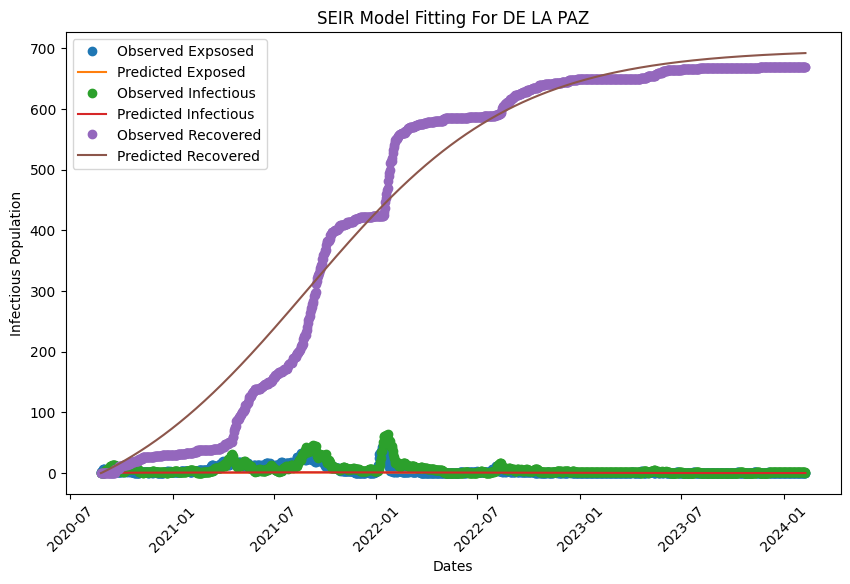

In [21]:
brgy_name = "DE LA PAZ"
main_df: pd.DataFrame = load_df("CITY_OF_BIÑAN_processed.csv")
df_observed_data: pd.DataFrame = load_observed(main_df, brgy_name) # Change to check for other Brgys.
# i_observed_data = df_observed_data['count_Infectious'].to_numpy()

# Initial parameters
N = 33235  # Population from google search (how to get from data?)
I0 = df_observed_data['count_Infectious'].iloc[0]
E0 = df_observed_data['count_Exposed'].iloc[0]
R0 = df_observed_data['count_Recovered'].iloc[0]
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions = [S0, E0, I0, R0] # List of initial conditions for SEIR

# Format of observed data should be a tuple of numpy arrays
observed_data = (
    df_observed_data['count_Exposed'].to_numpy(),       
    df_observed_data['count_Infectious'].to_numpy(),    
    df_observed_data['count_Recovered'].to_numpy()      
)


#print(type(initial_conditions))

# Time points 
time_points = np.arange(df_observed_data.shape[0]) # odeint expects an array (vector) of integers.


# Simulated Annealing parameters
temp = 25000           # Initial temperature
cooling_rate = 0.90    # Cooling rate
max_iter = 25000       # Number of iterations


# Run the Simulated Annealing algorithm
best_params, best_cost = simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter)
o_beta, o_sigma, o_gamma = best_params

# Display results
print(f"Best parameters: Beta={o_beta:.3f}, Sigma={o_sigma:.3f}, Gamma={o_gamma:.3f}")
print(f"Best cost (MSE): {best_cost:.3f}")

# Visualize the results
predicted_data = simulate_seir(o_beta, o_sigma, o_gamma, initial_conditions, time_points)

plot_actual = pd.DataFrame({
    'date': df_observed_data['date'],
    'count_Exposed': df_observed_data['count_Exposed'],
    'count_Infectious': df_observed_data['count_Infectious'],
    'count_Recovered': df_observed_data['count_Recovered']
})

plot_prediction = pd.DataFrame({
    'date': df_observed_data['date'],
    'count_Exposed': predicted_data[0],
    'count_Infectious': predicted_data[1],
    'count_Recovered': predicted_data[2]
})

plt.figure(figsize=(10, 6))
plt.plot(plot_actual['date'], plot_actual['count_Exposed'], 'o', label='Observed Expsosed')
plt.plot(plot_prediction['date'], plot_prediction['count_Exposed'], '-', label='Predicted Exposed')
plt.plot(plot_actual['date'], plot_actual['count_Infectious'], 'o', label='Observed Infectious')
plt.plot(plot_prediction['date'], plot_prediction['count_Infectious'], '-', label='Predicted Infectious')
plt.plot(plot_actual['date'], plot_actual['count_Recovered'], 'o', label='Observed Recovered')
plt.plot(plot_prediction['date'], plot_prediction['count_Recovered'], '-', label='Predicted Recovered')
plt.xlabel('Dates')
plt.ylabel('Infectious Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name}')
plt.show()